# Modélisation et Suivi des Expérimentations avec MLFlow

Ce notebook est dédié à la modélisation du score de prédiction et au suivi des expérimentations à l'aide de MLFlow. 
L'objectif est de tracer toutes les étapes de modélisation, depuis le prétraitement des données jusqu'à l'entraînement 
et l'évaluation des modèles, tout en enregistrant les résultats dans MLFlow pour faciliter l'analyse et la comparaison.

### Étapes couvertes :
1. Chargement et préparation des données
2. Entraînement des modèles
3. Suivi des expérimentations avec MLFlow
4. Comparaison des modèles et analyse des performances
5. Analyse de la contribution des variables avec SHAP


## Model a try : Dummy classifier , linear regression logistique , random forest classifier et gradiant boosting clasifier (ou ada boost)

 Utiliser : stratified kfold > pour split le dataset > préciser les col sur lesquels stratifié et garder qu'une partie du dataset


 suivre mlflow
 param 
 model 
 metrics 
 

In [1]:
# Import des bibliothèques principales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, make_scorer
from sklearn.preprocessing import MinMaxScaler
import mlflow
import mlflow.sklearn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from mlflow.tracking import MlflowClient

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


import tqdm as notebook_tqdm

import warnings
warnings.filterwarnings('ignore')

# Initialisation de MLFlow
mlflow.set_tracking_uri("file:./mlruns")  # dossier local pour le tracking
mlflow.set_experiment("Projet_Scoring")

print("Configuration et MLFlow initialisés.")

# augmenter l'allocation mémoire pour améliorer les temps d'éxécution
# Augmenter les limites de numpy et pandas 
np.set_printoptions(threshold=np.inf)
pd.options.display.max_rows = None
pd.options.display.max_columns = None

import psutil
import os
os.environ["PYTHONMALLOC"] = "default"  # allocation mémoire par défaut sans restriction

# Afficher la mémoire totale disponible
total_memory = psutil.virtual_memory().total
print(f"Total memory available: {total_memory / (1024 ** 3):.2f} GB")

Configuration et MLFlow initialisés.
Total memory available: 31.91 GB


## Chargement et Préparation des Donnéestes.


In [2]:
# Chargement des datasets enrichis (features métiers)
domain_features_train = pd.read_csv("ProcessedData/app_train_domain.csv")
domain_features_train = domain_features_train.dropna()
domain_features_test = pd.read_csv("ProcessedData/app_test_domain.csv")
domain_features_test = domain_features_test.dropna()
train_labels = domain_features_train["TARGET"]

# Vérification des dimensions
print(f"Train Shape: {domain_features_train.shape}, Test Shape: {domain_features_test.shape}")
print(f"Labels Shape: {train_labels.shape}")

Train Shape: (10746, 245), Test Shape: (2221, 244)
Labels Shape: (10746,)


## Fonction Standardisée pour le Tracking MLFlow

Suivie des résultat avec MLFlow :
- Hyperparamètres (mlflow.log_params(params))
- Temps de d'éxécution (.fit et .predict_proba)
- Scores 
    - AUC (mlflow.log_metric("AUC", auc_score))
    - Score Métier (mlflow.log_metric("business_score", business_score))
- Model (mlflow.sklearn.log_model(model, "model"))
- Courbes ROC (mlflow.log_artifact("roc_curve.png"))

In [3]:
def track_experiment(model_name, model, params, X_train, y_train, X_test, y_test):
    # Création d'un client MLFlow local
    client = MlflowClient()

    # Récupérer l'expérience MLFlow
    experiment = next((exp for exp in client.search_experiments() if exp.name == model_name), None)
    
    if not experiment:
        experiment_id = mlflow.create_experiment(model_name)
        print(f" Suivi MLFlow : {model_name} (ID: {experiment_id})")
    else:
        experiment_id = experiment.experiment_id
        print(f" Utilisation de l'expérience existante : {model_name} (ID: {experiment_id})")

    with mlflow.start_run(experiment_id=experiment_id, run_name=model_name):
        
        # Hyperparamètres
        mlflow.log_params(params)
        
        # Fit et son temps
        start_fit = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_fit
        mlflow.log_metric("fit_time", fit_time)
        
        # predict_proba et son temps
        start_pred = time.time()
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        prediction_time = time.time() - start_pred
        mlflow.log_metric("prediction_time", prediction_time)
        
        # Calcul des scores
        auc_score = roc_auc_score(y_test, y_pred_proba)
        business_score = calculate_business_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        auc_test = roc_auc_score(y_test, y_pred_proba)
        threshold_optimal = calculate_optimal_threshold(y_test, y_pred_proba)

        # Enregistrement des scores
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("business_score", business_score)
        mlflow.log_metric("F1", f1)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("AUC_test", auc_test)
        mlflow.log_metric("threshold_optimal", threshold_optimal)
        
        # Enregistrement du modèle
        mlflow.sklearn.log_model(model, "model")
        
        # Courbe ROC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve for {model_name}")
        plt.legend()
        plt.grid()
        plt.savefig("roc_curve.png")
        mlflow.log_artifact("roc_curve.png")
        plt.show()  # display dans le notebook
        
        print(f" {model_name} enregistré dans MLFlow")
        return model

## Score métier

In [4]:
# Fonction de calcul du coût / score métier
def calculate_business_score(y_true, y_pred, cost_fn=10, cost_fp=1):
    cm = confusion_matrix(y_true, y_pred)
    fn = cm[1, 0]  # Faux négatifs
    fp = cm[0, 1]  # Faux positifs
    print(f"Confusion Matrix:\n{cm}")
    print(f"FN: {fn}, FP: {fp}, Cost: {cost_fn * fn + cost_fp * fp}")
    return cost_fn * fn + cost_fp * fp

In [5]:
# Fonction de calcul du seuil optimal basé sur le coût métier
def calculate_optimal_threshold(y_true, y_pred_proba):
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    costs = [10 * (1 - tpr[i]) + (fpr[i]) for i in range(len(thresholds))]
    best_threshold = thresholds[costs.index(min(costs))]
    
    return best_threshold

### Intégration dans GridSearchCV

In [6]:
# business_scorer = make_scorer(calculate_business_score, greater_is_better=False)
# f1_scorer = make_scorer(f1_score)
# Utilisation de la ligne directement dans le grid search

## Optimisation et Comparaison de Modèles

Comparaison de plusieurs versions de modèles en utilisant GridSearchCV pour optimiser les hyperparamètres et suivi des expérimentations avec MLFlow

In [7]:
from sklearn.model_selection import train_test_split

# Chargement des données
X = domain_features_train.drop(columns=['TARGET']) 
y = train_labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Vérification de l'équilibre des classes
print(f"Répartition des classes :\n{y.value_counts(normalize=True)}")

Répartition des classes :
TARGET
0    0.938861
1    0.061139
Name: proportion, dtype: float64


Rappel :  
TARGET = 0 = prêts remboursés à temps  
TARGET = 1 = de prêts non remboursés

In [8]:
# Définition du nombre de splits pour la validation croisée
n_splits = 5
stratified_kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

### 1.DummyClassifie

In [9]:
# from sklearn.dummy import DummyClassifier

# # DummyClassifier avec rééquilibrage des classes
# dummy_model = DummyClassifier(strategy="most_frequent")

# # Évaluation du modèle avec validation croisée
# auc_scores = []
# business_scores = []

# for train_index, val_index in stratified_kfold.split(X, y):
#     # Séparation en train et validation
#     X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
#     y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
    
#     # Entraînement du modèle
#     dummy_model.fit(X_train_fold, y_train_fold)
    
#     # Prédictions probabilistes
#     y_pred_proba = dummy_model.predict_proba(X_val_fold)[:, 1]
#     y_pred = dummy_model.predict(X_val_fold)
    
#     # Calcul du score AUC
#     auc = roc_auc_score(y_val_fold, y_pred_proba)
#     auc_scores.append(auc)
    
#     # Calcul du score métier
#     business_score = calculate_business_score(y_val_fold, y_pred)
#     business_scores.append(business_score)

# # Affichage des résultats
# print(f"Score AUC moyen : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
# print(f"Score Métier moyen : {np.mean(business_scores):.4f}")


In [10]:
from sklearn.dummy import DummyClassifier

# DummyClassifier avec rééquilibrage des classes
pipeline_dummy = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('dummy', DummyClassifier(strategy="most_frequent"))
])

# GridSearchCV pour DummyClassifier
param_grid_dummy = {}

# Exécution de la validation croisée
grid_search_dummy = GridSearchCV(
    estimator=pipeline_dummy,
    param_grid=param_grid_dummy,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score', 
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

# Entraînement du GridSearchCV
grid_search_dummy.fit(X_train, y_train)

# Meilleurs résultats / scores pour DummyClassifier
mean_auc_dummy = grid_search_dummy.cv_results_['mean_test_AUC'][grid_search_dummy.best_index_]
mean_business_score_dummy = abs(grid_search_dummy.cv_results_['mean_test_business_score'][grid_search_dummy.best_index_])
y_test_proba_dummy = grid_search_dummy.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_dummy = roc_auc_score(y_test, y_test_proba_dummy)

print(f"\n Score AUC moyen (cross-val) DummyClassifier : {mean_auc_dummy:.4f}")
print(f"Score AUC du fichier test DummyClassifier : {auc_test_dummy:.4f}")
print(f"\n Score métier moyen (cross-val) DummyClassifier : {mean_business_score_dummy:.4f}")
for i in range(n_splits):
    split_score_dummy = abs(grid_search_dummy.cv_results_[f'split{i}_test_business_score'][grid_search_dummy.best_index_])
    print(f"Score métier pour split {i} DummyClassifier : {split_score_dummy:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
y_pred_dummy = grid_search_dummy.best_estimator_.predict(X_test)
print(f"Score métier réel sur le test set DummyClassifier : {calculate_business_score(y_test, y_pred_dummy)}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits

 Score AUC moyen (cross-val) DummyClassifier : 0.5000
Score AUC du fichier test DummyClassifier : 0.5000

 Score métier moyen (cross-val) DummyClassifier : 1052.0000
Score métier pour split 0 DummyClassifier : 1060.0000
Score métier pour split 1 DummyClassifier : 1050.0000
Score métier pour split 2 DummyClassifier : 1050.0000
Score métier pour split 3 DummyClassifier : 1050.0000
Score métier pour split 4 DummyClassifier : 1050.0000
Confusion Matrix:
[[2019    0]
 [ 131    0]]
FN: 131, FP: 0, Cost: 1310
Score métier réel sur le test set DummyClassifier : 1310


 Utilisation de l'expérience existante : DummyClassifier_Baseline (ID: 362639597066879707)
Confusion Matrix:
[[2019    0]
 [ 131    0]]
FN: 131, FP: 0, Cost: 1310


2025/02/14 11:28:54 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


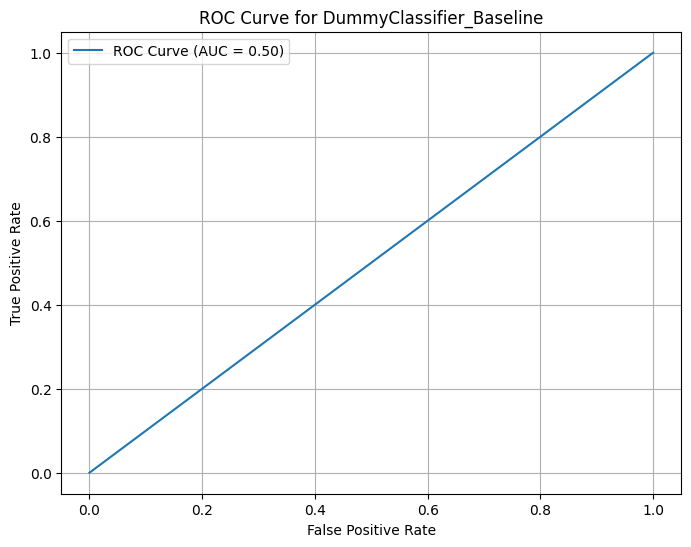

 DummyClassifier_Baseline enregistré dans MLFlow


In [11]:
# Paramètres du DummyClassifier
params = {"strategy": "most_frequent"}

# Exécution du tracking avec MLFlow
best_dummy = track_experiment(
    "DummyClassifier_Baseline",
    pipeline_dummy,
    params,
    X_train, y_train,
    X_test, y_test
)

In [12]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "DummyClassifier_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9391
AUC: 0.5000
AUC_test: 0.5000
business_score: 1310.0000
F1: 0.0000
fit_time: 0.1265
prediction_time: 0.0010
threshold_optimal: 0.0000

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('dummy', DummyClassifier(strategy='most_frequent'))])


## 2. linear regression logistique

In [13]:
from sklearn.linear_model import LogisticRegression

# Pipeline avec Smote sur LogisticRegression
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('logistic', LogisticRegression(solver="liblinear", random_state=42))
])

# Hyperparamètres pour LogisticRegression
# Préfixé par model__ car pipline avec imblearn
param_grid = {
    'logistic__C': [0.01, 0.1, 1, 10, 100],
}

# GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score', 
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params = grid_search.best_params_
mean_auc = grid_search.cv_results_['mean_test_AUC'][grid_search.best_index_]
mean_business_score = abs(grid_search.cv_results_['mean_test_business_score'][grid_search.best_index_])
y_test_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
auc_test = roc_auc_score(y_test, y_test_proba)

print(f"\n Meilleurs paramètres : {best_params}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc:.4f}")
print(f"Score AUC du fichier test : {auc_test:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score:.4f}")
for i in range(n_splits):
    split_score = abs(grid_search.cv_results_[f'split{i}_test_business_score'][grid_search.best_index_])
    print(f"Score métier pour split {i} : {split_score:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits

 Meilleurs paramètres : {'logistic__C': 1}

 Score AUC moyen (cross-val) : 0.6235
Score AUC du fichier test : 0.5932

 Score métier moyen (cross-val) : 1070.8000
Score métier pour split 0 : 1029.0000
Score métier pour split 1 : 1125.0000
Score métier pour split 2 : 992.0000
Score métier pour split 3 : 1034.0000
Score métier pour split 4 : 1174.0000


Confusion Matrix:
[[1205  814]
 [  62   69]]
FN: 62, FP: 814, Cost: 1434
Score métier réel sur le test set : 1434


 Utilisation de l'expérience existante : LogisticRegression_Baseline (ID: 871764857391792836)
Confusion Matrix:
[[1205  814]
 [  62   69]]
FN: 62, FP: 814, Cost: 1434


2025/02/14 11:29:15 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


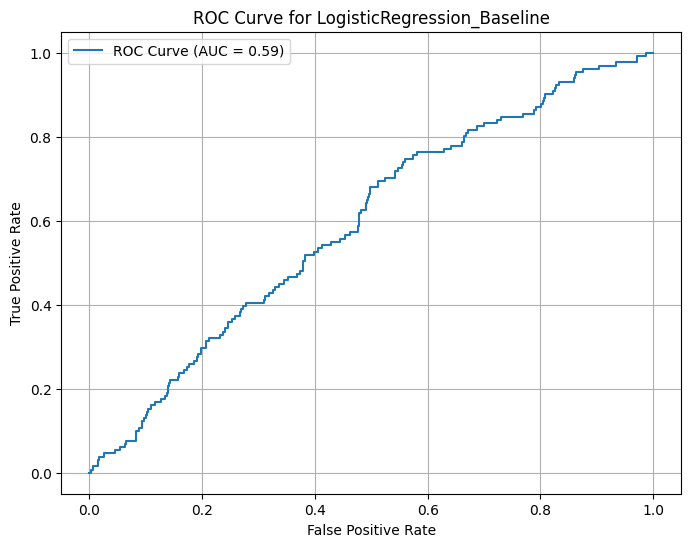

 LogisticRegression_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logistic',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])

In [14]:
# Enregistrer les résultats dans MLFlow
params = {
    'sampling_strategy': 'auto',
    'C': best_params['logistic__C']
}

track_experiment(
    "LogisticRegression_Baseline",
    grid_search.best_estimator_,
    params,
    X_train, y_train,
    X_test, y_test
)

In [15]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "LogisticRegression_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.5926
AUC: 0.5932
AUC_test: 0.5932
business_score: 1434.0000
F1: 0.1361
fit_time: 1.1216
prediction_time: 0.0130
threshold_optimal: 0.1340

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('logistic',
                 LogisticRegression(C=1, random_state=42, solver='liblinear'))])


## 3. RandomForestClassifier

In [16]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec SMOTE et RandomForestClassifier
pipeline_rf = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# Hyperparamètres pour RandomForest
param_grid_rf = {
    'rf__n_estimators': [1, 10, 100],
    'rf__max_depth': [None, 1, 10, 50]
}

# GridSearchCV pour RandomForest
grid_search_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_rf = grid_search_rf.best_params_
mean_auc_rf = grid_search_rf.cv_results_['mean_test_AUC'][grid_search_rf.best_index_]
mean_business_score_rf = abs(grid_search_rf.cv_results_['mean_test_business_score'][grid_search_rf.best_index_])
y_test_proba_rf = grid_search_rf.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_rf = roc_auc_score(y_test, y_test_proba_rf)


print(f"\n Meilleurs paramètres : {best_params_rf}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_rf:.4f}")
print(f"Score AUC du fichier test : {auc_test_rf:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_rf:.4f}")
for i in range(n_splits):
    split_score_rf = abs(grid_search_rf.cv_results_[f'split{i}_test_business_score'][grid_search_rf.best_index_])
    print(f"Score métier pour split {i} : {split_score_rf:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_rf.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

 Meilleurs paramètres : {'rf__max_depth': 10, 'rf__n_estimators': 100}

 Score AUC moyen (cross-val) : 0.6556
Score AUC du fichier test : 0.6396

 Score métier moyen (cross-val) : 1028.8000
Score métier pour split 0 : 1035.0000
Score métier pour split 1 : 1011.0000
Score métier pour split 2 : 1029.0000
Score métier pour split 3 : 1048.0000
Score métier pour split 4 : 1021.0000


Confusion Matrix:
[[1992   27]
 [ 125    6]]
FN: 125, FP: 27, Cost: 1277

 Score métier réel sur le test set : 1277


 Utilisation de l'expérience existante : RandomForest_Baseline (ID: 979903023935882380)
Confusion Matrix:
[[1992   27]
 [ 125    6]]
FN: 125, FP: 27, Cost: 1277


2025/02/14 11:29:55 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


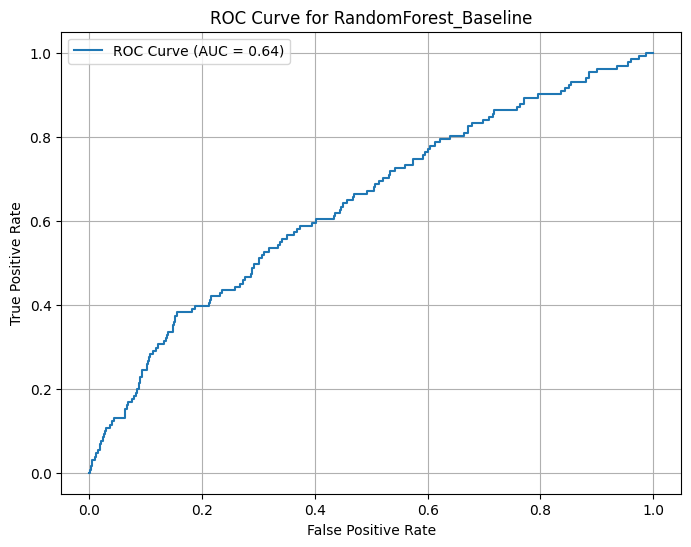

 RandomForest_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])

In [17]:
# Enregistrement dans MLFlow
params_rf = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_rf['rf__n_estimators'],
    'max_depth': best_params_rf['rf__max_depth']
}

track_experiment(
    "RandomForest_Baseline",
    grid_search_rf.best_estimator_,
    params_rf,
    X_train, y_train,
    X_test, y_test
)

In [18]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "RandomForest_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9293
AUC: 0.6396
AUC_test: 0.6396
business_score: 1277.0000
F1: 0.0732
fit_time: 4.8674
prediction_time: 0.0537
threshold_optimal: 0.0510

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf', RandomForestClassifier(max_depth=10, random_state=42))])


## 3. GradientBoostingClassifier

In [19]:
from sklearn.ensemble import GradientBoostingClassifier

# Pipeline avec SMOTE et GradientBoostingClassifier
pipeline_gb = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])

# Hyperparamètres pour GradientBoostingClassifier
param_grid_gb = {
    'gb__n_estimators': [10, 50, 100],
    'gb__max_depth': [10, 50, 100]
}

# GridSearchCV pour GradientBoostingClassifier
grid_search_gb = GridSearchCV(
    estimator=pipeline_gb,
    param_grid=param_grid_gb,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_gb.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_gb = grid_search_gb.best_params_
mean_auc_gb = grid_search_gb.cv_results_['mean_test_AUC'][grid_search_gb.best_index_]
mean_business_score_gb = abs(grid_search_gb.cv_results_['mean_test_business_score'][grid_search_gb.best_index_])
y_test_proba_gb = grid_search_gb.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_gb = roc_auc_score(y_test, y_test_proba_gb)


print(f"\n Meilleurs paramètres : {best_params_gb}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_gb:.4f}")
print(f"Score AUC du fichier test : {auc_test_gb:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_gb:.4f}")
for i in range(n_splits):
    split_score_gb = abs(grid_search_gb.cv_results_[f'split{i}_test_business_score'][grid_search_gb.best_index_])
    print(f"Score métier pour split {i} : {split_score_gb:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_gb.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Meilleurs paramètres : {'gb__max_depth': 10, 'gb__n_estimators': 10}

 Score AUC moyen (cross-val) : 0.6431
Score AUC du fichier test : 0.6226

 Score métier moyen (cross-val) : 1030.6000
Score métier pour split 0 : 1027.0000
Score métier pour split 1 : 1037.0000
Score métier pour split 2 : 1074.0000
Score métier pour split 3 : 1015.0000
Score métier pour split 4 : 1000.0000


Confusion Matrix:
[[1970   49]
 [ 122    9]]
FN: 122, FP: 49, Cost: 1269

 Score métier réel sur le test set : 1269


 Utilisation de l'expérience existante : GradientBoosting_Baseline (ID: 197559212266179280)
Confusion Matrix:
[[1970   49]
 [ 122    9]]
FN: 122, FP: 49, Cost: 1269


2025/02/14 11:40:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


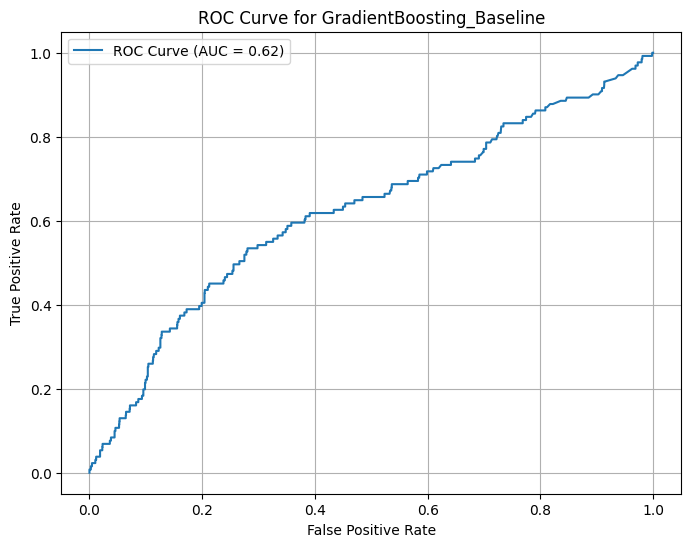

 GradientBoosting_Baseline enregistré dans MLFlow


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=42))])

In [20]:
# Enregistrement dans MLFlow
params_gb = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_gb['gb__n_estimators'],
    'max_depth': best_params_gb['gb__max_depth']
}

track_experiment(
    "GradientBoosting_Baseline",
    grid_search_gb.best_estimator_,
    params_gb,
    X_train, y_train,
    X_test, y_test
)

In [21]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "GradientBoosting_Baseline"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

 Métriques enregistrées dans MLFlow :
accuracy: 0.9205
AUC: 0.6226
AUC_test: 0.6226
business_score: 1269.0000
F1: 0.0952
fit_time: 9.1200
prediction_time: 0.0120
threshold_optimal: 0.1785

 Modèle enregistrées dans MLFlow :
Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('gb',
                 GradientBoostingClassifier(max_depth=10, n_estimators=10,
                                            random_state=42))])


## Fine tuning du modèle RandomForest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline avec SMOTE et RandomForestClassifier
pipeline_rff = Pipeline([
    ('smote', SMOTE(sampling_strategy='auto', random_state=42)),
    ('rff', RandomForestClassifier(random_state=42))
])

# Hyperparamètres pour RandomForest
param_grid_rff = {
    'rff__n_estimators': [140,150,160],
    'rff__max_depth': [9,10],
    'rff__min_samples_split': [8, 10, 12],
    'rff__min_samples_leaf': [2, 3]
}

# GridSearchCV pour RandomForest
grid_search_rff = GridSearchCV(
    estimator=pipeline_rff,
    param_grid=param_grid_rff,
    scoring={
        'AUC': 'roc_auc',
        'Accuracy': 'accuracy',
        'business_score': make_scorer(calculate_business_score, greater_is_better=False),
        'threshold_optimal': make_scorer(calculate_optimal_threshold, needs_proba=True),
        'F1': make_scorer(f1_score)
    },
    refit='business_score',
    cv=stratified_kfold,
    n_jobs=-1,
    verbose=1
)

grid_search_rff.fit(X_train, y_train)

# Meilleurs paramètres / résultats / scores
best_params_rff = grid_search_rff.best_params_
mean_auc_rff = grid_search_rff.cv_results_['mean_test_AUC'][grid_search_rff.best_index_]
mean_business_score_rff = abs(grid_search_rff.cv_results_['mean_test_business_score'][grid_search_rff.best_index_])
y_test_proba_rff = grid_search_rff.best_estimator_.predict_proba(X_test)[:, 1]
auc_test_rff = roc_auc_score(y_test, y_test_proba_rff)


print(f"\n Meilleurs paramètres : {best_params_rff}")
print(f"\n Score AUC moyen (cross-val) : {mean_auc_rff:.4f}")
print(f"Score AUC du fichier test : {auc_test_rff:.4f}")
print(f"\n Score métier moyen (cross-val) : {mean_business_score_rff:.4f}")
for i in range(n_splits):
    split_score_rff = abs(grid_search_rff.cv_results_[f'split{i}_test_business_score'][grid_search_rff.best_index_])
    print(f"Score métier pour split {i} : {split_score_rff:.4f}")

# Vérification du score retourné par la fonction en dehors de GridSearchCV
print("\n")
y_pred = grid_search_rff.best_estimator_.predict(X_test)
print(f"\n Score métier réel sur le test set : {calculate_business_score(y_test, y_pred)}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# Enregistrement dans MLFlow
params_rff = {
    'sampling_strategy': 'auto',
    'n_estimators': best_params_rff['rff__n_estimators'],
    'max_depth': best_params_rff['rff__max_depth'],
    'min_samples_split': best_params_rff['rff__min_samples_split'],
    'min_samples_leaf': best_params_rff['rff__min_samples_leaf']
}

track_experiment(
    "RandomForest_FineTuned",
    grid_search_rff.best_estimator_,
    params_rff,
    X_train, y_train,
    X_test, y_test
)

In [ ]:
client = MlflowClient()

# Récupération de l'expérience MLFlow
experiment_name = "RandomForest_FineTuned"
experiment = next((exp for exp in client.search_experiments() if exp.name == experiment_name), None)

if experiment:
    experiment_id = experiment.experiment_id
    runs = client.search_runs(experiment_ids=[experiment_id], order_by=["attributes.start_time desc"])
    
    # Affichage de toutes les métriques stockées dans MLFlow
    print(" Métriques enregistrées dans MLFlow :")
    for metric, value in runs[0].data.metrics.items():
        print(f"{metric}: {value:.4f}")

    # et du model
    model = mlflow.sklearn.load_model(runs[0].info.artifact_uri + "/model")
    print("\n Modèle enregistrées dans MLFlow :")
    print(model)

## Feature importance
#### Feature importance globale

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1000x600 with 0 Axes>

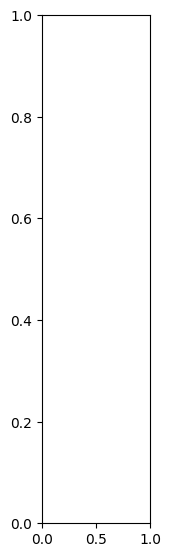

In [25]:
import shap

best_model_rff = grid_search_rff.best_estimator_.named_steps['rff']

# SHAP
explainer = shap.TreeExplainer(best_model_rff)
shap_values = explainer(X_test)

#Feature importance globale
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.show()

#### Feature importance locale (du 1er élément)

In [ ]:
#Feature importance locale
shap.waterfall_plot(shap_values[0])

# IGNORER A PARTIR D'ICI

In [ ]:
pd.dataframe

- Environnement GIT pour avoir plusieurs commit
- modifier model fine tuned par RandomForest
- Modifier SHAP global avec box plot
- Vérifier et corriger la feature importance locale aussi (pk les deux premier ont un impact autant signifiactif par rapport aux autres)

- API :
    -  

## Feature Importance avec SHAP


Utilisation de la bibliothèque SHAP pour analyser l'importance globale et locale des variables

In [ ]:
import shap
import numpy as np
import pandas as pd

# Sous-échantillonnage pour limiter les calculs
sample_size = 100
domain_features_sample = domain_features_train[:sample_size]  # Assurez-vous que domain_features_train est un DataFrame

# Récupération des noms des features
feature_names = domain_features_train.columns

# Conversion explicite en NumPy pour SHAP si nécessaire
domain_features_sample_np = domain_features_sample.to_numpy()

# Initialisation de SHAP TreeExplainer avec le modèle entraîné
explainer = shap.TreeExplainer(best_model)

# Calcul des valeurs SHAP
shap_values = explainer.shap_values(domain_features_sample_np)

print("SHAP values calculés avec succès !")

In [ ]:
# Visualisation globale pour la classe 1 (mauvais prospect)
class_index = 1  # Analyse pour la classe 1
shap.summary_plot(
    shap_values[..., class_index],  # SHAP values pour la classe
    domain_features_sample,         # Les données originales
    feature_names=feature_names,    # Les noms des colonnes
    max_display=10                  # Limiter l'affichage
)


In [ ]:
# Affichage local pour un client spécifique
client_index = 0  # Premier client
class_index = 1  # Classe 1 (mauvais prospect)

shap.force_plot(
    explainer.expected_value[class_index],  # Base value pour la classe 1
    shap_values[client_index, :, class_index],  # SHAP values pour le client et la classe
    domain_features_sample_np[client_index],  # Données du client (NumPy)
    feature_names=feature_names.tolist(),  # Noms des features
    matplotlib=True
)


# Sauvegarde et Conclusion

Les résultats de cette analyse, ainsi que les modèles optimisés, sont sauvegardés pour un usage futur. 
Ils seront utilisés pour :
- Le déploiement de l'API de prédiction.
- La présentation des résultats dans le cadre de la soutenance.

### Étapes :
1. Sauvegarder les résultats des modèles et des expérimentations.
2. Finaliser le notebook pour qu’il soit prêt à être intégré dans le livrable final.
